# Product Recommendations – Popularity-based and Collaborative Filtering models


### Data Source:
http://jmcauley.ucsd.edu/data/amazon/

Electronics (ratings only) dataset: This dataset includes no metadata or reviews, but only (user,item,rating,timestamp) tuples.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.sparse
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

### Data Ingestion

### Q1. Read and explore the dataset.  ( Rename column, plot histograms, find data characteristics)

In [2]:
ratings_df = pd.read_csv('ratings_Electronics.csv', header=None)
ratings_df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = ratings_df.drop('timestamp', axis=1)
df = ratings_df.copy(deep=True)
ratings_df.head()

,user_id,item_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [3]:
ratings_df.tail()

,user_id,item_id,rating
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0


In [4]:
ratings_df.index

RangeIndex(start=0, stop=7824482, step=1)

In [5]:
# Check for missing values
print('Number of missing values across columns-\n', ratings_df.isnull().sum())

Number of missing values across columns-
 user_id    0
item_id    0
rating     0
dtype: int64


In [6]:
# Summary statistics of 'rating' variable
ratings_df[['rating']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


(array([  901765.,        0.,   456322.,        0.,        0.,   633073.,
               0.,  1485781.,        0.,  4347541.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

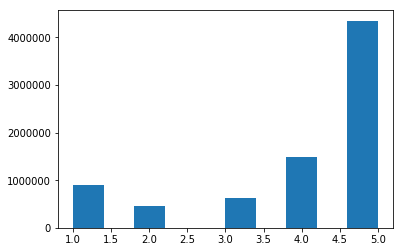

In [7]:
plt.hist(ratings_df['rating'])

In [8]:
# No. of rows and columns
ratings_df.shape

(7824482, 3)

In [9]:
# number of unique elements
print('No. of unique USERS in ratings_df = ', ratings_df['user_id'].nunique())
print('No. of unique ITEMS in ratings_df = ', ratings_df['item_id'].nunique())

No. of unique USERS in ratings_df =  4201696
No. of unique ITEMS in ratings_df =  476002


### Q2. Take subset of dataset to make it less sparse/more dense. ( For example, keep the users only who has given 50 or more number of ratings )

In [10]:
# No. of items each user rated
user_item_df = pd.DataFrame()
user_item_df = ratings_df.groupby('user_id').count()
user_item_df.head()

,item_id,rating
user_id,,
A00000262KYZUE4J55XGL,1,1
A000063614T1OE0BUSKUT,2,2
A00009182QVLSWIGHLS1B,1,1
A00009661LC9LQPGKJ24G,1,1
A00010809P09NUU6ZP6H,1,1


In [11]:
user_item_df.index

Index(['A00000262KYZUE4J55XGL', 'A000063614T1OE0BUSKUT',
       'A00009182QVLSWIGHLS1B', 'A00009661LC9LQPGKJ24G',
       'A00010809P09NUU6ZP6H', 'A00014061C2IZNE0YEILY',
       'A000145014WOTZJ5NSKOR', 'A00015222LZ55IJSVL5IX',
       'A00015228CUPGPF957DS', 'A0001528BGUBOEVR6T5U',
       ...
       'AZZZDSAJ757Z4', 'AZZZEWADNFNUM', 'AZZZJXM9GW3C5', 'AZZZM2FO19RUO',
       'AZZZMSZI9LKE6', 'AZZZOVIBXHGDR', 'AZZZRS1YZ8HVP', 'AZZZSIK7NFFVP',
       'AZZZWXXUPZ1F3', 'AZZZY1W55XHZR'],
      dtype='object', name='user_id', length=4201696)

In [12]:
user_item_df = user_item_df.drop('rating', axis=1)
user_item_df.columns = ['no._of_items_rated']
# user_item_df has unique users and total no. of items each user rated
user_item_df.head()

,no._of_items_rated
user_id,
A00000262KYZUE4J55XGL,1
A000063614T1OE0BUSKUT,2
A00009182QVLSWIGHLS1B,1
A00009661LC9LQPGKJ24G,1
A00010809P09NUU6ZP6H,1


In [13]:
user_item_df.shape

(4201696, 1)

In [14]:
# keep the users (only) who have given 50 or more number of ratings and remove others
user_item_df[user_item_df['no._of_items_rated'] < 50] = np.nan
user_item_df.head()

,no._of_items_rated
user_id,
A00000262KYZUE4J55XGL,NaN
A000063614T1OE0BUSKUT,NaN
A00009182QVLSWIGHLS1B,NaN
A00009661LC9LQPGKJ24G,NaN
A00010809P09NUU6ZP6H,NaN


In [15]:
# Remove users who have rated less than 50 items
user_item_df = user_item_df.dropna()
user_item_df.head()

,no._of_items_rated
user_id,
A100UD67AHFODS,116.0
A100WO06OQR8BQ,132.0
A105S56ODHGJEK,68.0
A105TOJ6LTVMBG,71.0
A10AFVU66A79Y1,65.0


In [16]:
user_item_df['no._of_items_rated'] = user_item_df['no._of_items_rated'].astype(int)
# Users who have rated 50 or more items
user_item_df.shape

(1540, 1)

In [17]:
print('No. of users who have rated 50 or more items =', user_item_df.shape[0])
user_item_df.head()

No. of users who have rated 50 or more items = 1540


,no._of_items_rated
user_id,
A100UD67AHFODS,116
A100WO06OQR8BQ,132
A105S56ODHGJEK,68
A105TOJ6LTVMBG,71
A10AFVU66A79Y1,65


In [18]:
# unique users who have rated 50 or more items
users_list = user_item_df.index.tolist()
len(users_list)

1540

In [19]:
print('ratings_df.shape =', ratings_df.shape)

# final_ratings_df contains users' data for only users who have rated 50 or more items
final_ratings_df = ratings_df.loc[ratings_df['user_id'].isin(users_list)]
print('final_ratings_df.shape =', final_ratings_df.shape)

ratings_df.shape = (7824482, 3)
final_ratings_df.shape = (125871, 3)


In [20]:
print('No. of unique users who have rated 50 or more items =', len(users_list))
print('No. of unique USERS in final_ratings_df = ', final_ratings_df['user_id'].nunique())
print('No. of unique ITEMS in final_ratings_df = ', final_ratings_df['item_id'].nunique())

No. of unique users who have rated 50 or more items = 1540
No. of unique USERS in final_ratings_df =  1540
No. of unique ITEMS in final_ratings_df =  48190


#### Observation: 'final_ratings_df' has users only who have rated 50 or more items

#### To calulate density of 'final_ratings_df'

In [21]:
final_ratings_mat = final_ratings_df.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
print('Shape of final_ratings_mat: ', final_ratings_mat.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_mat)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_mat.shape[0] * final_ratings_mat.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density_final_ratings_mat = round(given_num_of_ratings/possible_num_of_ratings, 4)
print('\nDensity of final_ratings_mat = ', density_final_ratings_mat)

Shape of final_ratings_mat:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600

Density of final_ratings_mat =  0.0017


In [22]:
final_ratings_mat.head()

item_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Q3. Split the data randomly into train and test dataset. ( For example split it in 70/30 ratio)

In [23]:
train_data, test_data = train_test_split(final_ratings_df, test_size = 0.3, random_state=7)

"""Making a copy of 'test_data'(which has ACTUAL ratings by users) and 
storing it in 'user_rated_testdata' which will be used during Model Evaluation"""

user_rated_testdata = test_data.copy(deep=True)

print("Masking the actual ratings given by the users in 'test_data'")
test_data.rating = np.nan
test_data.head()

Masking the actual ratings given by the users in 'test_data'


,user_id,item_id,rating
1106621,A1RPTVW5VEOSI,B000K5VD2E,NaN
7577499,A213J54E63SYOP,B00EYVNFMG,NaN
3628707,A17V9XL4CWTQ6G,B003W5QCTI,NaN
2709001,A3V7D0LH8L7BG0,B002MAPS6W,NaN
1700241,ATNOI7E8GTIVE,B0015A8Y3E,NaN


### Q4. Build Popularity Recommender model. (Non-personalised)

In [24]:
# Using train_data to recommend top-5 items based on popularity
pop_items_df = train_data.groupby('item_id')['rating'].mean().sort_values(ascending=False).head()
pop_items_list = pop_items_df.index.tolist()

print('\nTop-5 items recommended by the model(irrespective of the user) are below:\n')
print('Item-ids: ', pop_items_list)
print('\n(Since this is a popularity-based recommender model, recommendations remain the same for all users)')


Top-5 items recommended by the model(irrespective of the user) are below:

Item-ids:  ['B003A0T6YS', 'B002PU9SQU', 'B002PK1COG', 'B002PKDIYI', 'B002PLQ8WG']

(Since this is a popularity-based recommender model, recommendations remain the same for all users)


In [25]:
# How many items were actually purchased in the "test_data" from the top-5 recommended-items listed above?
temp = user_rated_testdata.loc[user_rated_testdata['item_id'].isin(pop_items_list)]
temp = temp.groupby('item_id').count()
temp

,user_id,rating
item_id,,
B002PK1COG,1,1
B002PLQ8WG,1,1
B002PU9SQU,5,5
B003A0T6YS,1,1


In [26]:
temp = temp.drop('rating', axis=1)
temp.columns = ['no._of_users_purchased']
temp

,no._of_users_purchased
item_id,
B002PK1COG,1
B002PLQ8WG,1
B002PU9SQU,5
B003A0T6YS,1


In [27]:
print('Popularity-based recommended items: ', pop_items_list)

Popularity-based recommended items:  ['B003A0T6YS', 'B002PU9SQU', 'B002PK1COG', 'B002PKDIYI', 'B002PLQ8WG']


In [28]:
rec_items = len(temp)
print('\n{} out of 5 recommended-items were purchased in "test_data"'.format(rec_items))

rec_items_purchases_tot = temp['no._of_users_purchased'].sum()
total_items = user_rated_testdata['item_id'].nunique()
print('\nNo. of unique items purchased in the "test_data" =', total_items )
print('\nTotally there were {0} purchases of recommended-items out of {1} total purchases in "test_data"'.format(rec_items_purchases_tot, len(user_rated_testdata)))


4 out of 5 recommended-items were purchased in "test_data"

No. of unique items purchased in the "test_data" = 21403

Totally there were 8 purchases of recommended-items out of 37762 total purchases in "test_data"


### Q5. Build Collaborative Filtering model.

#### Model-based Collaborative Filtering: Singular Value Decomposition

In [29]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail() # 'rating' is set to 'NaN' for test_data

,index,user_id,item_id,rating
125866,5082378,AUITG1DJ3QUGK,B005MECHLY,NaN
125867,2247232,A2YW6XOID7GV6G,B001QVHO38,NaN
125868,5001842,A1PM7HH4F77NEH,B005IDTH76,NaN
125869,6783658,A17UNMURMLX0ZE,B009YQ8BTI,NaN
125870,7756956,AOEDWQLH2WKKW,B00HMREOLK,NaN


In [30]:
# Matrix with one row per 'user' and one column per 'item' 
R_df = df_CF.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
print(R_df.shape)
R_df.head()

(1540, 48190)


item_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# User-Item Utility matrix
R_df.head()

item_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
R_df['user_index'] = np.arange(0, R_df.shape[0], 1)
R_df.head()

item_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [33]:
R_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
R_df.head()

item_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD method

In [34]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(R_df, k = 50)

In [35]:
# Extract diagonal array
sigma = np.diag(sigma)
sigma

array([[  55.88015599,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,   55.97972992,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,   56.18614206, ...,    0.        ,
           0.        ,    0.        ],
       ..., 
       [   0.        ,    0.        ,    0.        , ...,   83.46422055,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
          91.14167169,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,  133.52586729]])

In [36]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

item_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.001776,-0.005203,0.001531,-0.017565,-0.004204,0.002675,0.016072,-0.001570,0.011045,0.002009,...,0.000704,0.026654,0.0,0.023013,-0.017580,0.0,0.004999,-0.127166,0.003772,0.0
1,0.001160,0.005385,0.002245,0.032823,0.005278,0.001682,0.034248,0.004176,-0.001612,0.001422,...,-0.001089,0.005234,0.0,-0.035585,-0.041884,0.0,0.003751,-0.022638,-0.022982,0.0
2,-0.000326,0.002832,-0.008076,0.039536,0.015400,0.001041,0.008699,0.009107,-0.000152,0.000924,...,-0.000557,-0.003235,0.0,-0.050723,-0.044578,0.0,-0.001389,0.101787,-0.075886,0.0
3,0.004298,0.008909,-0.016878,-0.007806,0.000140,0.001714,-0.009105,-0.001712,0.006992,0.001494,...,-0.000628,0.003735,0.0,-0.014995,0.006857,0.0,-0.001285,-0.025616,0.015996,0.0
4,0.003244,0.001442,0.012223,0.016854,0.003923,0.003120,0.019577,0.003723,-0.001483,0.002655,...,-0.000101,0.016006,0.0,-0.001379,-0.006185,0.0,0.003159,0.070776,0.025676,0.0


In [37]:
# Recommend the items with the highest predicted ratings that the specified user hasn’t already rated

def recommend_items(userID, R_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = R_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    
    # Get and sort the predicted-ratings for the user
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    #print(temp.head())

    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))
    

In [44]:
################### Enter 'userID' and 'num_recommendations' for the user #####################
userID = 7
num_recommendations = 5
recommend_items(userID, R_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 7):

                   user_ratings  user_predictions
Recommended Items                                
B00834SJSK                  0.0          0.498823
B0034CL2ZI                  0.0          0.472728
B001E1Y5O6                  0.0          0.399952
B002V88HFE                  0.0          0.398571
B004T9RR6I                  0.0          0.321885


### Q6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

#### Evaluation of Model-based Collaborative Filtering (SVD)

In [46]:
# Actual ratings given by the users
final_ratings_mat.head()

item_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Average ACTUAL rating for each item
final_ratings_mat.mean().head()

item_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [48]:
# Predicted ratings 
preds_df.head()

item_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.001776,-0.005203,0.001531,-0.017565,-0.004204,0.002675,0.016072,-0.001570,0.011045,0.002009,...,0.000704,0.026654,0.0,0.023013,-0.017580,0.0,0.004999,-0.127166,0.003772,0.0
1,0.001160,0.005385,0.002245,0.032823,0.005278,0.001682,0.034248,0.004176,-0.001612,0.001422,...,-0.001089,0.005234,0.0,-0.035585,-0.041884,0.0,0.003751,-0.022638,-0.022982,0.0
2,-0.000326,0.002832,-0.008076,0.039536,0.015400,0.001041,0.008699,0.009107,-0.000152,0.000924,...,-0.000557,-0.003235,0.0,-0.050723,-0.044578,0.0,-0.001389,0.101787,-0.075886,0.0
3,0.004298,0.008909,-0.016878,-0.007806,0.000140,0.001714,-0.009105,-0.001712,0.006992,0.001494,...,-0.000628,0.003735,0.0,-0.014995,0.006857,0.0,-0.001285,-0.025616,0.015996,0.0
4,0.003244,0.001442,0.012223,0.016854,0.003923,0.003120,0.019577,0.003723,-0.001483,0.002655,...,-0.000101,0.016006,0.0,-0.001379,-0.006185,0.0,0.003159,0.070776,0.025676,0.0


In [51]:
# Average PREDICTED rating for each item
preds_df.mean().head()

item_id
0594451647    0.002192
0594481813    0.003240
0970407998    0.003148
0972683275    0.011004
1400501466    0.004565
dtype: float64

In [52]:
rmse_df = pd.concat([final_ratings_mat.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
item_id,,,
0594451647,0.003247,0.002192,0
0594481813,0.001948,0.003240,1
0970407998,0.003247,0.003148,2
0972683275,0.012338,0.011004,3
1400501466,0.012987,0.004565,4


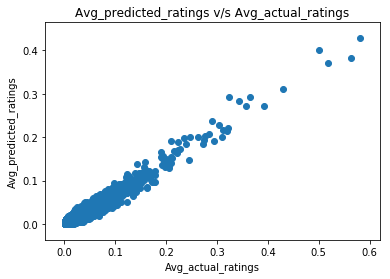

In [53]:
plt.scatter(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings)
plt.xlabel('Avg_actual_ratings')
plt.ylabel('Avg_predicted_ratings')
plt.title('Avg_predicted_ratings v/s Avg_actual_ratings')
plt.show()

In [54]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\n----------   RMSE for Model-based Collaborative Filtering (SVD) = {}   ---------- \n'.format(RMSE))


----------   RMSE for Model-based Collaborative Filtering (SVD) = 0.00613   ---------- 



#### Evaluation of Popularity-based recommender model

In [56]:
pop_items_testdata = user_rated_testdata.groupby('item_id')['rating'].mean().sort_values(ascending=False).head()
print('Top-5 items purchased in "test_data" are:')
pop_items_testdata

Top-5 items purchased in "test_data" are:


item_id
B00LKG1MC8    5.0
B0001FTVDQ    5.0
B0001FI49I    5.0
B003LNNOCO    5.0
B003LMPYDW    5.0
Name: rating, dtype: float64

In [57]:
print('Popularity-based Recommender Model recommended below items using "train_data":\n\n', pop_items_list)

Popularity-based Recommender Model recommended below items using "train_data":

 ['B003A0T6YS', 'B002PU9SQU', 'B002PK1COG', 'B002PKDIYI', 'B002PLQ8WG']


##### Observation: 
Top-5 items purchased in "test_data" were completely differnet from top-5 items recommended by the Popularity-based recommender model(using "train_data"). Major drawback is, there is no personalization involved with this approach.

### Q7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

#### Top-5 recommendations using Collaborative Filtering - SVD approach:

In [60]:
################### Enter 'userID' and 'num_recommendations' for the user #####################
userID = 99
num_recommendations = 5
recommend_items(userID, R_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 99):

                   user_ratings  user_predictions
Recommended Items                                
B005IMFX2K                  0.0          0.168683
B000U5TUWE                  0.0          0.130626
B001E1Y5O6                  0.0          0.129343
B001G1ZPV6                  0.0          0.121551
B009M27MB2                  0.0          0.118894


### Q8. Summarise your insights.

#### Insights:

Since Model-based Collaborative Filtering considers latent features and interactions between users and items, the recommendations make sense to the user. The recommendations will turn into purchase transactions more easily which enhances business. This algorithm is entirely based on the past behavior and not on the context. This makes it one of the most commonly used algorithm as it is not dependent on any additional information. 
    
    For example: product recommendations by e-commerce player like Amazon and merchant recommendations by banks like American Express extensively use this approach.

Whereas the Popularity-based recommender system is non-personalised and so the recommendations will not be of much use to the user. 
    
    But this approach still works in places like news portals to recommend 'Popular News' by category(IT, Entertainment, Finance, etc...)